## Crosstalk Interface

Here is what I hope to be an enlightening example of how the MMT can be used for crosstalk analysis. The setup below is for 90 and 150 GHz bands for a LAT. The 1728 constitutes about one wafer of multichroic detectors. The main parameter that will need to be changed is the path_to_positions, which is a path to a text file of the focal plane mapped to the sky in degrees. The current wafer_99.txt details the rhombus layout of wafer 99 as output by the instrument model. 

Feel free to email hryciuk@uchicago.edu if you have questions or comments. Thanks!

In [1]:
#path to a text file of detector positions on sky **USER CHANGE APPROPRIATELY**
#it is assumed that this file is in units of degrees so scale appropriately
path_to_positions = '/home/ahryciuk/CMBS4_Noise_Modeling/MapMultiTool/wafer_99.txt'

#frequencies represented in position data in GHz
freqs = [90,150]

num_det = 1728    #number of detectors (1 wafer is ~1722 which includes both 90 GHz and 150 GHz detectors)

#Map Parameters:
#rescale the field of view to ~2/3 of a degree spread in detectors on sky
#This rescales the field of view from a SAT packing density to a LAT packing density as is, but can certainly be changed 
rescale = 50. #(2/3) / 12.5 scales positions.txt to LAT FOV

N = 1024    #number of pixels in horizontal and vertical edges of maps
pixel_size = 0.25 * 1/60.    #size of each pixel in deg

#Main beam fwhm in deg
beam_fwhm = 1.5 * 1/60.

#Correlation Parameters:
freq1 = freqs[0]    #frequency in question
freq2 = freqs[0]    #frequency correlated to freq1
perc_corr = 0.03    #percent at which the signals are correlated
TtoP_suppress = True #suppress the T->P leakage that results from imbalanced detectors along certain polarization angles

#Power Spectrum Binning Parameters:
delta_ell = 50    #bin width
ell_max = 5000    #maximum ell

#Observation Parameters:
scan_sp = 3 #deg/s scan speed
tau_unc = 0.3 #30% uncertainty

#choose normalization of power spectra
## 0 normalizes all PS to 1 for use with biasing spectra
## 'TT', 'EE', 'BB' normalizes to a main spectrum to study leakage
choose_normalization = 'TT'

assert(choose_normalization in [0,'TT','EE','BB'])

#sky decomposition in I, Q, U space
sky_decomp = [1., 0, 0]

The wafer information has a spread of 0.44080578395103986 degrees in x
The wafer information has a spread of 0.5035732643614198 degrees in y
central beam values II:1.0, QQ:0.9999303992761526, UU:0.9999303992761526
IQ: 0.0
IU: 0.0
QI: 0.0
QU: 3.602798576932285e-05
UI: 0.0
UQ: -0.00013445827338548152


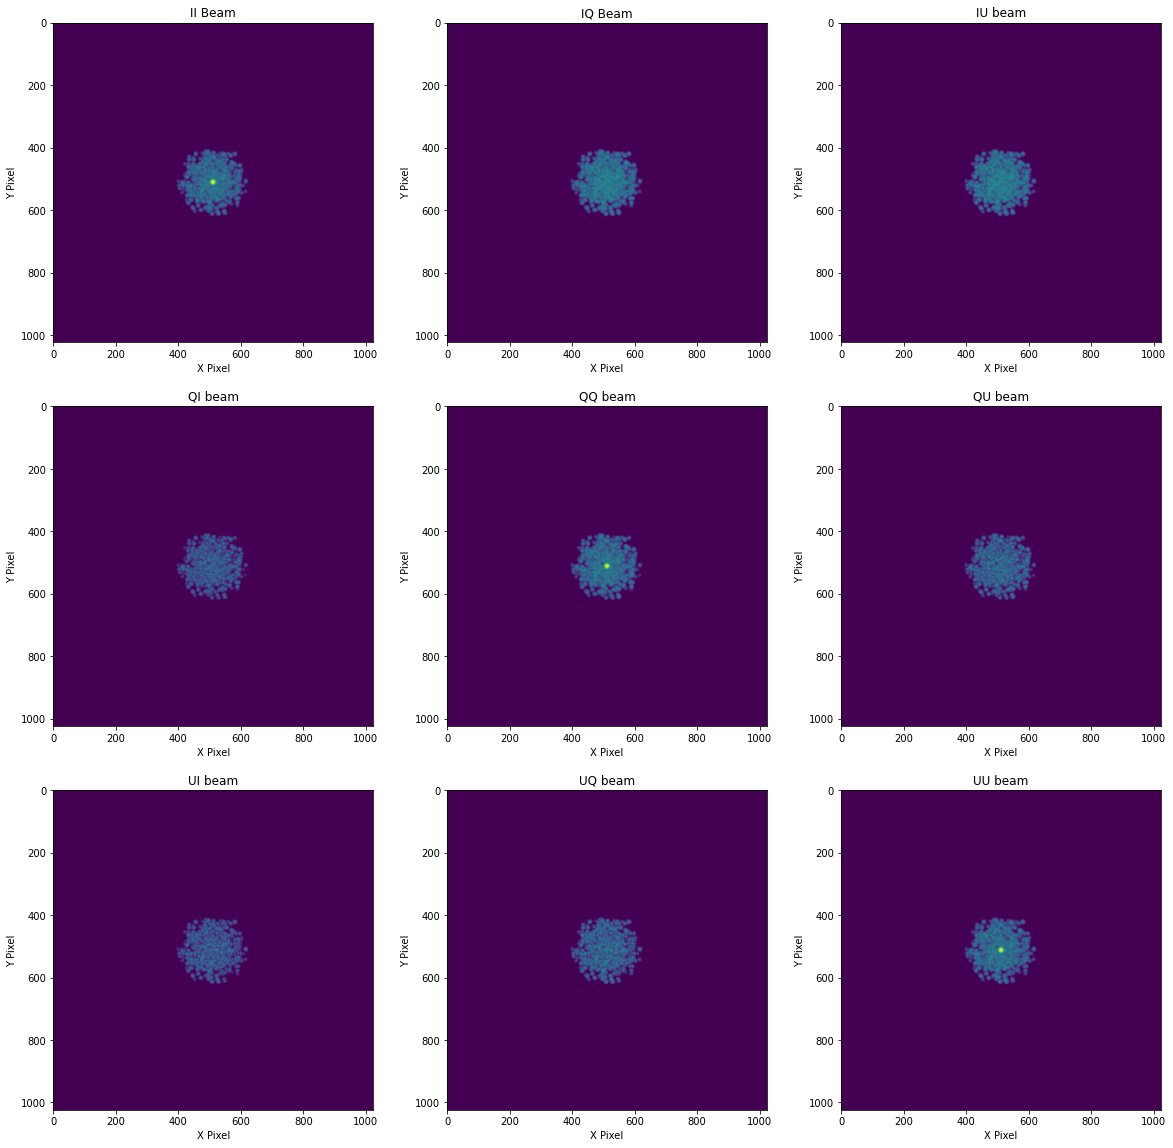

In [2]:
from MMTModules import *
%matplotlib inline
#use above parameters to calculate the beam matrix and display power spectra for a pure T sky


#generate focal plane distribution
det_dict = generate_focal_plane_distribution(path_to_positions, num_det, freqs, rescale)

#generate random coupling
coupling_dict = generate_random_coupling(det_dict)
#generate rhombus coupling
#coupling_dict = generate_bondpad_coupling_rhombus(det_dict)

#this is inefficient, doing the same calculation twice
unconvolved_beams = calculate_beam_matrix(det_dict, coupling_dict, freq1, freq2, pixel_size, perc_corr, N, TtoP_suppress = False, to_fft=False)

#calculate crosstalk 3x3 IQU beams
convolved_beam_matrix = calculate_crosstalk(det_dict, coupling_dict, [freq1,freq2], pixel_size, perc_corr, N, beam_fwhm, sky_decomp, TtoP_suppress, delta_ell, ell_max, choose_normalization,  unconvolved_beams=unconvolved_beams)


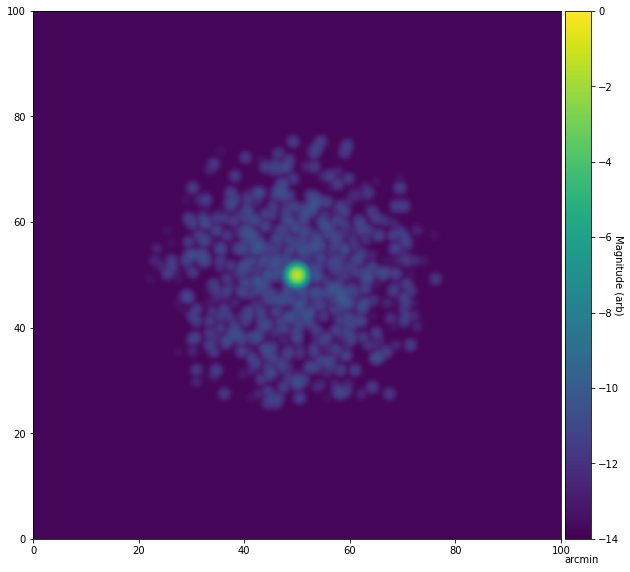

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

IIBeam = convolved_beam_matrix['II']
X_width = 400*pixel_size*60.
Y_width = X_width

plt.gcf().set_size_inches(10, 10)
im = plt.imshow(np.log(IIBeam[512-200:512+200,512-200:512+200]*(pixel_size*60.) + 0.000001),origin='lower')
im.set_clim(-14,0)

ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)

im.set_extent([0,X_width,0,Y_width])
plt.ylabel('Magnitude (arb)')
plt.xlabel('arcmin',labelpad=16.0,loc='left')

cbar.set_label('Magnitude (arb)', rotation=270)

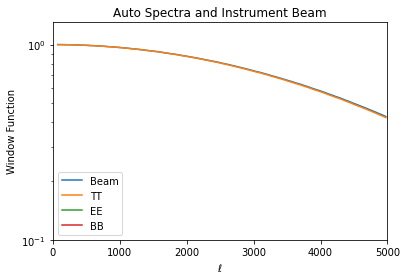

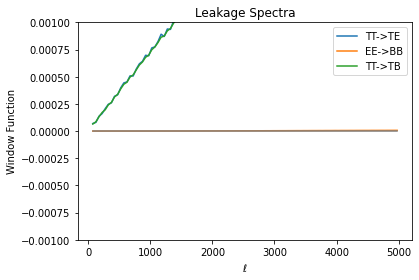

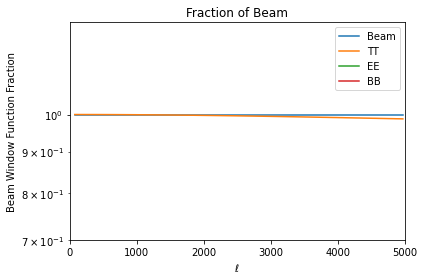

In [3]:
#combine to detector IQU array maps and make 2d FFTs and bin to 1d leakage spectra
binned_ell, binned_spectra = get_leakage_spectra(convolved_beam_matrix, pixel_size, N, beam_fwhm, sky_decomp, delta_ell, ell_max, choose_normalization)

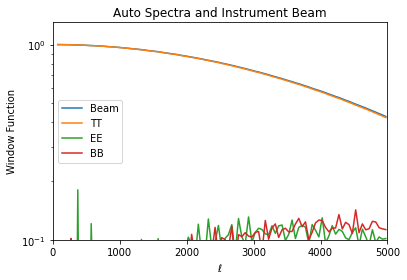

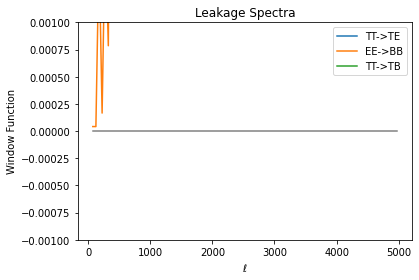

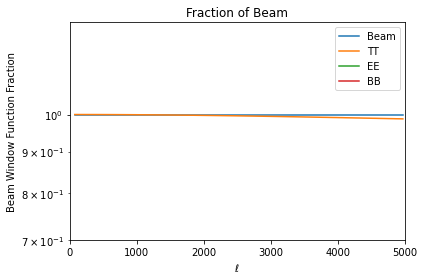

In [3]:
#calculate leakage beams (deproject input maps)
binned_ell, binned_spectra = get_leakage_beams(convolved_beam_matrix, unconvolved_beams, pixel_size, N, beam_fwhm, sky_decomp, delta_ell, ell_max, choose_normalization)

need to put in new normalization for leakages

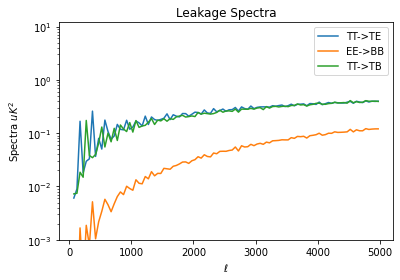

In [5]:
import numpy as np
import matplotlib.pyplot as plt
ell_convert = binned_ell[1:]*(binned_ell[1:] + 1)/(2*np.pi)
plt.semilogy( binned_ell[1:], binned_spectra['TE'])#/(norm_fac*binned_spectra_dict['TT']) )
plt.semilogy(binned_ell[1:], binned_spectra['EB'])#/(norm_fac*binned_spectra_dict['EE']) )
plt.semilogy(binned_ell[1:], binned_spectra['TB'])#/(norm_fac*binned_spectra_dict['TT']))
#plt.semilogy(binned_ell[1:], zero_line, color='gray')
cross_labels = ['TT->TE','EE->BB','TT->TB']
plt.legend(cross_labels)
plt.title('Leakage Spectra')
plt.ylabel('Spectra $uK^2$')
plt.xlabel('$\ell$')
plt.ylim(1e-3,1.2e1)
plt.show()

In order to line up the above transfer functions with the fiducial spectra for parameter estimation, I need to fit the above to a smooth function:

For now I am taking the curve fit weigting to be the standard deviation of the spectrum. To be completely accurate, multiple simulations generating many spectra would need to be taken, but given I took the randomness out of this simulation, this should not matter anymore.

Text(0, 0.5, 'Transfer Function')

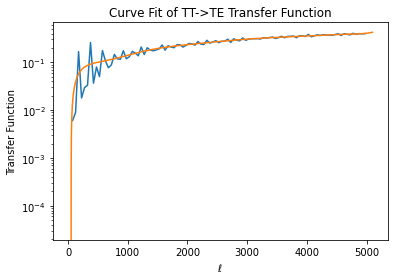

In [9]:
#define 9th order polynomial
def polynomial_9(x, a, b, c, d, e, f, g, h, i, j):
    return a*x**9. + b*x**8. + c*x**7. + d*x**6. + e*x**5. + f*x**4. + g*x**3. + h*x**2. + i*x + j

#For TE
import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = binned_ell[1:]
initial_guess = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(binned_spectra['TE']))
errors = sigma*np.ones(len(binned_spectra['TE']))
curve_fit = optimization.curve_fit(polynomial_9, ell_set, binned_spectra['TE'], initial_guess, errors)

parameters = curve_fit[0]
ell = np.arange(ell_max+101)
tf_fit = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])
plt.semilogy(binned_ell[1:],binned_spectra['TE'])
plt.semilogy(ell,tf_fit)
plt.title('Curve Fit of TT->TE Transfer Function')
plt.xlabel('$\ell$')
plt.ylabel('Transfer Function')

## Cobaya $N_\nu$ Central Value Shift

Below is as small of an interface as I could make to set up a Cobaya simulation for As,ns, and $N_\nu$. The above calculations could be organized into a dictionary to hand here which will bias the generated fiducial spectra. The simulation approximates the likelihoods as gaussian using TT, TE, and EE spectra. 

When run without a TF, the calculation should return the error on the sampler, which is random and on the order of subpercent.

$$C_\ell^{XY} = C_\ell^{XY} + \delta_\ell^{WV\rightarrow XY} C_\ell^{WV}$$

where $\delta_\ell^{WV\rightarrow XY}$ contains the leakage divided by the instrument beam (This assumes all the instrument beams are the same and the only difference comes from crosstalk.)

Gaussian Likelihood Approximation: $-2ln(L) = (X_c - \tilde{X_c})^T Cov(X_c) (X_c - \tilde{X_c})$
for a measured $X_c$ and a model $\tilde{X_c}$

Here:

$Cov(X_c)_\ell = \frac{\nu}{2(C^{TT}_\ell C^{EE}_\ell-(C^{TE}_\ell)^2)} \begin{pmatrix} (C^{EE}_\ell)^2 & -2C^{TE}_\ell C^{EE}_\ell & (C^{TE}_\ell)^2 \\ -2C^{TE}_\ell C^{EE}_\ell & 2(C^{TT}_\ell C^{EE}_\ell+(C^{TE}_\ell)^2) & -2C^{TE}_\ell C^{TT}_\ell \\ (C^{TE}_\ell)^2 & -2C^{TE}_\ell C^{TT}_\ell & (C^{TT}_\ell)^2 \end{pmatrix}$

where $\nu = 2(\ell+1)$

So

$-2ln(L) = \begin{pmatrix}C^{TT}_\ell - \tilde{C}^{TT}_\ell, & C^{TE}_\ell - \tilde{C}^{TE}_\ell, & C^{EE}_\ell - \tilde{C}^{EE}_\ell\end{pmatrix} \frac{(2\ell+1)}{2(C^{TT}_\ell C^{EE}_\ell-(C^{TE}_\ell)^2)^2} \begin{pmatrix} (C^{EE}_\ell)^2 & -2C^{TE}_\ell C^{EE}_\ell & (C^{TE}_\ell)^2 \\ -2C^{TE}_\ell C^{EE}_\ell & 2(C^{TT}_\ell C^{EE}_\ell+(C^{TE}_\ell)^2) & -2C^{TE}_\ell C^{TT}_\ell \\ (C^{TE}_\ell)^2 & -2C^{TE}_\ell C^{TT}_\ell & (C^{TT}_\ell)^2 \end{pmatrix} \begin{pmatrix}C^{TT}_\ell - \tilde{C}^{TT}_\ell \\ C^{TE}_\ell - \tilde{C}^{TE}_\ell \\ C^{EE}_\ell - \tilde{C}^{EE}_\ell\end{pmatrix}$

In [1]:
from CobayaModules import *
import numpy as np

#parameters
lmax = 5100    #for accuracy to lmax of 5000
lmin = 10
packages_path = '/path/to/your/packages'
ell = np.arange(lmax+1)

#Define transfer functions
#TF_eff_dict = {}
#TF_eff_dict['TTTE'] = tf_fit[lmin:lmax+1]
TF_eff_dict = None


        
#fiducial LCDM
ombh2_fid = 0.022
omch2_fid = 0.12
H0_fid = 68.0
tau_fid = 0.07
As_fid = 2.2e-9
ns_fid = 0.96
thetastar_fid = 0.010409
nnu_fid = 3.046

#calculate fiducial spectra
Cl_fid = generate_fiducial(lmax = lmax, lmin = lmin, ombh2=ombh2_fid, omch2=omch2_fid,
                           thetastar=thetastar_fid, tau=tau_fid, As=As_fid, ns=ns_fid, nnu=nnu_fid)

#Cl_fid['EE'] = np.zeros(len(Cl_fid['TT']))
#Cl_fid['TE'] = np.zeros(len(Cl_fid['TT']))

#prior information (gaussian)
#NOTE: This information is irrelevant when using the minimizer
ombh2_sigma = 0.1
omch2_sigma = 0.1
H0_sigma = 0.1
tau_sigma = 0.1
As_sigma = 0.1
ns_sigma = 0.1

#reference distribution
#This is where the minimizer will draw the initial points from
perc = 0.05
ombh2_lower = ombh2_fid*(1-perc)
ombh2_upper = ombh2_fid*(1+perc)
omch2_lower = omch2_fid*(1-perc)
omch2_upper = omch2_fid*(1+perc)
H0_lower = H0_fid*(1-perc)
H0_upper = H0_fid*(1+perc)
thetastar_lower = thetastar_fid*(1-perc)
thetastar_upper = thetastar_fid*(1+perc)
tau_lower = tau_fid*(1-perc)
tau_upper = tau_fid*(1+perc)
As_lower = As_fid*(1-perc)
As_upper = As_fid*(1+perc)
ns_lower = ns_fid*(1-perc)
ns_upper = ns_fid*(1+perc)

#reference distribution is defined as uniform over range nnu_lower -> nnu_upper and serves as the initial sample for the chain
#the prior is a normal distribution centered at the fiducial value with some width nnu_sigma
nnu_lower = 1.0
nnu_upper = 5.0
nnu_sigma = 0.004



[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!


## Curve Fit the leakage spectra calculated above

In [5]:
#define 9th order polynomial
def polynomial_9(x, a, b, c, d, e, f, g, h, i, j):
    return a*x**9. + b*x**8. + c*x**7. + d*x**6. + e*x**5. + f*x**4. + g*x**3. + h*x**2. + i*x + j

import scipy.optimize as optimization
ell = np.arange(ell_max+101)
initial_guess = [0,0,0,0,0,0,0,0,0,0]

#loop thru the leakage spectra:
TF_eff_dict = {}
TF_eff_dict['pure T'] = {}
for spectra_key in binned_spectra.keys():

    if spectra_key is 'TE':
        sigma = np.sqrt(np.var(binned_spectra['TE']))
        errors = sigma*np.ones(len(binned_spectra['TE']))
        curve_fit = optimization.curve_fit(polynomial_9, binned_ell[1:], binned_spectra['TE'], initial_guess, errors)
        
        parameters = curve_fit[0]
        TF_eff_dict['pure T']['TTTE'] = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])[lmin:lmax+1]
    elif spectra_key is 'EE':
        sigma = np.sqrt(np.var(binned_spectra['EE']))
        errors = sigma*np.ones(len(binned_spectra['EE']))
        curve_fit = optimization.curve_fit(polynomial_9, binned_ell[1:], binned_spectra['EE'], initial_guess, errors)

        parameters = curve_fit[0]
        TF_eff_dict['pure T']['TTEE'] = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])[lmin:lmax+1]

In [6]:
TF_eff_dict = None

In [6]:
#define gaussian likelihood
#including TT, TE, EE in likelihood
def my_like_multi_spectra(
        # Parameters that we may sample over (or not)
        Cl_fid=Cl_fid,
        #TF_eff = TF_mag[8:l_max-1],
        TF_eff_dict = TF_eff_dict,
        # Keyword through which the cobaya likelihood instance will be passed.
        _self=None):
    import numpy as np
    
    # Cl of the map: data + noise
    Cl_map = {}
    
    #WATCHOUT: watch out for redefining when looping thru pure E and pure B keys with T in front
    if TF_eff_dict is not None:
        Cl_map = Cl_fid
        for tf_key in TF_eff_dict.keys():
            if tf_key is 'pure T':
                this_TT = Cl_fid['TT']
                Cl_map['TT'] = Cl_map['TT']
                Cl_map['TE'] = Cl_map['TE'] + TF_eff_dict['pure T']['TTTE']*this_TT
                Cl_map['EE'] = Cl_map['EE'] + TF_eff_dict['pure T']['TTEE']*this_TT
                
            elif tf_key is 'pure E':
                this_EE = Cl_fid['EE']
                Cl_map['TT'] = Cl_map['TT'] + TF_eff_dict['pure E']['EETT']*this_EE
                Cl_map['TE'] = Cl_map['TE'] + TF_eff_dict['pure E']['EETE']*this_EE
                Cl_map['EE'] = Cl_map['EE']
            
    else:
        Cl_map = Cl_fid
 
    # Request the Cl from the provider
    # I believe what this is is a snapshot of what the theoretical spectrum is at that particular set of sampled LCDM model
    Cl_theo_tt = _self.provider.get_Cl(ell_factor=False, units="muK2")['tt'][lmin:lmax+1]
    Cl_theo_ee = _self.provider.get_Cl(ell_factor=False, units="muK2")['ee'][lmin:lmax+1]
    Cl_theo_te = _self.provider.get_Cl(ell_factor=False, units="muK2")['te'][lmin:lmax+1]
    
    #Cl_map['TT'] = Cl_theo_tt
    #Cl_map['EE'] = Cl_theo_ee
    #Cl_map['TE'] = Cl_theo_te
    
    Cl_map_theo = {}
    Cl_map_theo['TT'] = Cl_theo_tt
    Cl_map_theo['EE'] = Cl_theo_ee
    Cl_map_theo['TE'] = Cl_theo_te
    
    #covariance matrix is the inverse of the wishart curvature
    Y_inv = np.array( ( (2*ell[lmin:lmax+1]+1) ) / ( 2*(Cl_map['TT']*Cl_map['EE'] - Cl_map['TE']**2.)**2. ) * [[Cl_map['EE']**2., -2*Cl_map['TE']*Cl_map['EE'], Cl_map['TE']**2.],
       [-2*Cl_map['EE']*Cl_map['TE'], 2*(Cl_map['TT']*Cl_map['EE']+Cl_map['TE']**2.), -2*Cl_map['TT']*Cl_map['TE']],
      [Cl_map['TE']**2., -2*Cl_map['TE']*Cl_map['TT'],Cl_map['TT']**2.]])
    
    #approximating the likelihood as gaussian
    d = np.array([Cl_map['TT'], Cl_map['TE'], Cl_map['EE']])
    m = np.array([Cl_map_theo['TT'], Cl_map_theo['TE'], Cl_map_theo['EE']])
#    d = np.array([Cl_map['EE'], Cl_map['TE'], Cl_map['TT']])
#    m = np.array([Cl_map_theo['EE'], Cl_map_theo['TE'], Cl_map_theo['TT']])
    #for whatever reason this was not working right with np.matmul
    curv = np.array([(Y_inv[0,0]*(d-m)[0])+(Y_inv[0,1]*(d-m)[1])+(Y_inv[0,2]*(d-m)[2]), 
                   (Y_inv[1,0]*(d-m)[0])+(Y_inv[1,1]*(d-m)[1])+(Y_inv[1,2]*(d-m)[2]), 
                   (Y_inv[2,0]*(d-m)[0])+(Y_inv[2,1]*(d-m)[1])+(Y_inv[2,2]*(d-m)[2])])
    
    #curv = np.matmul(Cov_inv,(d-m))
#    logp = np.sum( np.matmul(np.transpose(np.sum(d-m,axis=1)), curv) )
    logp = -np.sum((d-m)[0]*curv[0] + (d-m)[1]*curv[1] + (d-m)[2]*curv[2])
            
    # Set our derived parameter
    derived = {'Map_Cl_at_500': Cl_map['TT'][500]}
    return logp, derived

#Likelihood given biasing by some TF
def my_like_TT(
        # Parameters that we may sample over (or not)
        Cl_fid=Cl_fid,
        lmax = 5100,
        # Keyword through which the cobaya likelihood instance will be passed.
        _self=None):
    
    '''
    Liklihood function including TF affecting the 'measured'
    spectrum when comparing to the fiducial.
    '''
    
    # Cl of the map: data + noise
    Cl_map = Cl_fid['TT']
    
    # Request the Cl from the provider
    # I believe what this is is a snapshot of what the theoretical spectrum is at that particular set of sampled LCDM model
    Cl_theo = _self.provider.get_Cl(ell_factor=False, units="muK2")['tt'][lmin:lmax+1]
    Cl_map_theo = Cl_theo
    
    #apply transfer function from systematics
    #Cl_map = TF_eff * Cl_map
    
    # ----------------
    # Compute the log-likelihood
    V = Cl_map/Cl_map_theo
    #V = Cl_map/Cl_fid
    logp = np.sum((2*ell[lmin:lmax+1]+1)*(-V/2 +1/2.*np.log(V)))
    # Set our derived parameter
    derived = {'Map_Cl_at_500': Cl_map[500]}
    return logp, derived 

In [7]:
#use above leakage spectra calculation (TE,TB,EB) to bias fiducial spectra
#TF_TE = binned_spectra['TE']
#TF_TB = binned_spectra['TB']
#TF_EB = binned_spectra['EB']

#initialize
#info = initialize_simulation(Nl=None, TF_eff=None, As_lower=1e-9, As_upper=4e-9, As_fid = 2.2e-9, ns_lower=0.9, ns_upper=1.1, ns_fid=0.96, nnu_lower=3.04, nnu_upper=3.05, nnu_fid=3.046)

info = {
        'params': {
            # Fixed
#            'tau': tau_fid,
#            'thetastar':thetastar_fid,
#            'H0':H0_fid,
#            'mnu': 0.06,
#            'ombh2': ombh2_fid,
#            'omch2': omch2_fid,
#            'As': As_fid,
#            'ns': ns_fid,
#            'nnu': nnu_fid,
            # Sampled
#            'nnu': {'prior': {'min': nnu_lower, 'max': nnu_upper}, 'latex': 'nnu','ref':{'dist': 'norm', 'loc':3.046, 'scale':0.06}},
#            'nnu':{'prior':{'min':3.03,'max':3.06},'ref':{'min':3.03,'max':3.06}, 'latex':'nnu'},
#            'ombh2':{'prior':{'min':ombh2_lower,'max':ombh2_upper},'ref':{'min':ombh2_lower,'max':ombh2_upper},'latex':'ombh2'},
            'ombh2':{'prior':{'min':ombh2_lower,'max':ombh2_upper},'ref':ombh2_fid,'latex':'ombh2'},
#            'omch2':{'prior':{'min':omch2_lower,'max':omch2_upper},'ref':{'min':omch2_lower,'max':omch2_upper},'latex':'omch2'},
            'omch2':{'prior':{'min':omch2_lower,'max':omch2_upper},'ref':omch2_fid,'latex':'omch2'},
#            'H0':{'prior':{'min':H0_lower,'max':H0_upper},'ref':{'min':H0_lower,'max':H0_upper},'latex':'H0'},
#            'tau':{'prior':{'min':tau_lower,'max':tau_upper},'ref':{'min':tau_lower,'max':tau_upper},'latex':'tau'},
            'tau':{'prior':{'min':tau_lower,'max':tau_upper},'ref':tau_fid,'latex':'tau'},
#            'thetastar':{'prior':{'min':thetastar_lower,'max':thetastar_upper},'ref':{'min':thetastar_lower,'max':thetastar_upper},'latex':'thetastar'},
            'thetastar':{'prior':{'min':thetastar_lower,'max':thetastar_upper},'ref':thetastar_fid,'latex':'thetastar'},
#            'As':{'prior':{'min':As_lower,'max':As_upper},'ref':{'min':As_lower,'max':As_upper},'latex':'As'},
            'As':{'prior':{'min':As_lower,'max':As_upper},'ref':As_fid,'latex':'As'},
#            'ns':{'prior':{'min':ns_lower,'max':ns_upper},'ref':{'min':ns_lower,'max':ns_upper},'latex':'ns'},
            'ns':{'prior':{'min':ns_lower,'max':ns_upper},'ref':ns_fid,'latex':'ns'},
#            'nnu':{'prior':{'min':nnu_lower,'max':nnu_upper},'ref':{'min':nnu_lower,'max':nnu_upper}, 'latex':'nnu'}},
            'nnu':{'prior':{'min':nnu_lower,'max':nnu_upper},'ref':nnu_fid, 'latex':'nnu'}},
        
        'likelihood': {'my_cl_like': {
            "external": my_like_multi_spectra,
#            "internal":likelihood.Likelihood.logp,
            # Declare required quantities!
            "requires": {'Cl': {'tt': lmax,'te':lmax,'ee':lmax}}}},
        'theory': {'camb': {'stop_at_error': True}},
#        'sampler':'mcmc',
        'packages_path': packages_path}


#calculate
from cobaya.model import get_model
model = get_model(info)

[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[my_cl_like] Initialized external likelihood.


### Using mcmc Sampler

In [20]:
# Optional: define an output driver
from cobaya.output import get_output
out = get_output(prefix="chains/my_model", resume=False, force=True)

# Initialise and run the sampler
info_sampler = {"mcmc": {"Rminus1_stop":0.001, "max_samples": 2,'max_tries':1000}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model,
                   packages_path=info["packages_path"])
mcmc.run()

# Print results
print(mcmc.products()["sample"]) 

[output] Output to be read-from/written-into folder 'chains', with prefix 'my_model'
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_cl_like: 1050.0, camb.transfers: 1.61, camb: 2.59}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: nnu:3.047
[mcmc] Sampling!
[mcmc] Progress @ 2021-08-24 15:11:53 : 1 steps taken, and 0 accepted.
[mcmc] Progress @ 2021-08-24 15:12:53 : 105 steps taken, and 0 accepted.
[mcmc] Progress @ 2021-08-24 15:13:53 : 217 steps taken, and 1 accepted.
[mcmc] Reached maximum number of accepted steps allowed. Stopping.
[mcmc] Sampling complete after 2 accepted steps.
   weight   minuslogpost       nnu  Map_Cl_at_500  minu

### Using minimize Sampler

works with just nnu, but when introduce other parameters it gets wonky. The minimized solution is dependent on the initial point and doesn't converge to the fiducial for all the parameters. Often it converges to an extreme. I've tried changing the width of the reference distribution and prior to no avail. 

The single parameter approach works for: nnu, omch2, ns, thetastar and does not work for: ombh2, As
I tried combinations of the parameters that supposedly work and they do not work when combined.

I've also tried both scipy (derivative minimization) and bobyqa (non-derivative minimization) algorithms. 

In [10]:
# Optional: define an output driver
from cobaya.output import get_output
out = get_output(prefix="chains/my_model", resume=False, force=True)

# Initialize the minimize sampler
info_sampler = {"minimize": {'method':'bobyqa','ignore_prior':False,'override_bobyqa':{'rhoend':0.001}}}
from cobaya.sampler import get_sampler
minimize = get_sampler(info_sampler, model=model,
                   packages_path=info["packages_path"])


[output] Output to be read-from/written-into folder 'chains', with prefix 'my_model'
[minimize] Initializing
[minimize] Starting from random initial point:
[minimize] {'ombh2': 0.022, 'omch2': 0.12, 'tau': 0.07, 'thetastar': 0.010409, 'As': 2.2e-09, 'ns': 0.96, 'nnu': 3.046}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.


In [11]:
#Run single minimize
minimize.run()

[minimize] Starting minimization.
[root] Function eval 1 at point 1 has f = -45.5661675291523 at x = [...]
[root] Initialising (coordinate directions)
[root] Function eval 2 at point 2 has f = 196.295597429099 at x = [...]
[root] Function eval 3 at point 3 has f = 198.564937295848 at x = [...]
[root] Function eval 4 at point 4 has f = -41.3145962032641 at x = [...]
[root] Function eval 5 at point 5 has f = 16876.1893901257 at x = [...]
[root] Function eval 6 at point 6 has f = 378.602456079901 at x = [...]
[root] Function eval 7 at point 7 has f = 671.641266812957 at x = [...]
[root] Function eval 8 at point 8 has f = 29570.2860432117 at x = [...]
[root] Function eval 9 at point 9 has f = 196.267405815381 at x = [...]
[root] Function eval 10 at point 10 has f = 196.549758331641 at x = [...]
[root] Function eval 11 at point 11 has f = -41.311221268064 at x = [...]
[root] Function eval 12 at point 12 has f = 17843.724983238 at x = [...]
[root] Function eval 13 at point 13 has f = 376.892

[root] Function eval 87 at point 87 has f = 1385.32524032806 at x = [...]
[root] Function eval 88 at point 88 has f = 2676.65544372372 at x = [...]
[root] Function eval 89 at point 89 has f = 1698.77442663684 at x = [...]
[root] Function eval 90 at point 90 has f = 1468.08542953619 at x = [...]
[root] Soft restart [currently, f = 1385.33 after 90 function evals]
[root] Function eval 91 at point 91 has f = 1766.33128578406 at x = [...]
[root] Function eval 92 at point 92 has f = 6887.47963357259 at x = [...]
[root] Function eval 93 at point 93 has f = 4595.75788267155 at x = [...]
[root] Function eval 94 at point 94 has f = 9148.38470877491 at x = [...]
[root] New rho = 0.05 after 94 function evaluations
[root] Function eval 95 at point 95 has f = 3525.97091109122 at x = [...]
[root] Function eval 96 at point 96 has f = 1183.98035056383 at x = [...]
[root] Function eval 97 at point 97 has f = 952.977226480574 at x = [...]
[root] Function eval 98 at point 98 has f = 2409.58311035311 at x

[root] Function eval 178 at point 178 has f = 1279.91650519534 at x = [...]
[root] Slow iteration (1 consecutive so far, max allowed 140)
[root] Function eval 179 at point 179 has f = 3677.33609621736 at x = [...]
[root] Function eval 180 at point 180 has f = 1151.19894935233 at x = [...]
[root] Slow iteration (2 consecutive so far, max allowed 140)
[root] Function eval 181 at point 181 has f = 1122.6718817644 at x = [...]
[root] Function eval 182 at point 182 has f = 869.562961772369 at x = [...]
[root] Slow iteration (3 consecutive so far, max allowed 140)
[root] Function eval 183 at point 183 has f = 1135.7979166961 at x = [...]
[root] Soft restart [currently, f = 869.563 after 183 function evals]
[root] Function eval 184 at point 184 has f = 42458.1952086348 at x = [...]
[root] Function eval 185 at point 185 has f = 153952.92905604 at x = [...]
[root] Function eval 186 at point 186 has f = 34777.7331151495 at x = [...]
[root] Function eval 187 at point 187 has f = 2526.39110333486 

[root] Slow iteration (5 consecutive so far, max allowed 140)
[root] Function eval 265 at point 265 has f = 3376.99436213535 at x = [...]
[root] Function eval 266 at point 266 has f = 1848.24339648748 at x = [...]
[root] Function eval 267 at point 267 has f = 1207.09788412558 at x = [...]
[root] Function eval 268 at point 268 has f = 1543.94119002419 at x = [...]
[root] Function eval 269 at point 269 has f = 1832.8513131713 at x = [...]
[root] Function eval 270 at point 270 has f = 3121.56625144643 at x = [...]
[root] Function eval 271 at point 271 has f = 1277.52885844201 at x = [...]
[root] Function eval 272 at point 272 has f = 5578.01268442682 at x = [...]
[root] Function eval 273 at point 273 has f = 1499.88351457171 at x = [...]
[root] Function eval 274 at point 274 has f = 2584.00401716326 at x = [...]
[root] Function eval 275 at point 275 has f = 1242.54651106263 at x = [...]
[root] Soft restart [currently, f = 1207.1 after 275 function evals]
[root] Function eval 276 at point 

[root] Function eval 356 at point 356 has f = 367.13938999462 at x = [...]
[root] Function eval 357 at point 357 has f = 312.393308117239 at x = [...]
[root] Function eval 358 at point 358 has f = 332.856826802843 at x = [...]
[root] Soft restart [currently, f = 312.393 after 358 function evals]
[root] Function eval 359 at point 359 has f = 93311.4740952558 at x = [...]
[root] Function eval 360 at point 360 has f = 126740.595641366 at x = [...]
[root] Function eval 361 at point 361 has f = 302639.840632679 at x = [...]
[root] Function eval 362 at point 362 has f = 2076.12744236912 at x = [...]
[root] Function eval 363 at point 363 has f = 990.653798479203 at x = [...]
[root] Slow iteration (1 consecutive so far, max allowed 140)
[root] Function eval 364 at point 364 has f = 4346.14465273442 at x = [...]
[root] Function eval 365 at point 365 has f = 2133.6849631268 at x = [...]
[root] New rho = 0.05 after 365 function evaluations
[root] Function eval 366 at point 366 has f = 548.9830623

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!


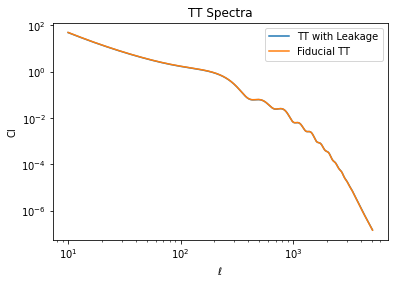

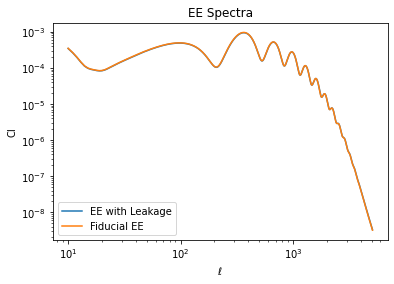

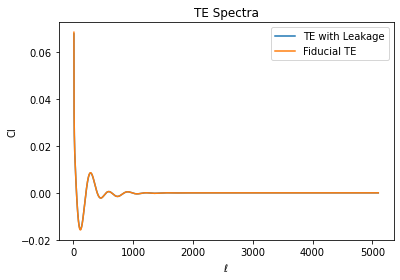

In [14]:
#what does this solution look like?
import matplotlib.pyplot as plt

#ombh2_min = minimize.products()['minimum']['ombh2']
#omch2_min = minimize.products()['minimum']['omch2']
#tau_min = minimize.products()['minimum']['tau']
#As_min = minimize.products()['minimum']['As']
#ns_min = minimize.products()['minimum']['ns']
#thetastar_min = minimize.products()['minimum']['thetastar']
#nnu_min = minimize.products()['minimum']['nnu']\

ombh2_min = 0.022
omch2_min = 0.119
tau_min = 0.07
As_min = 2.178e-9
ns_min = 0.96
thetastar_min = 0.0104
nnu_min = 2.932

Cl_min = generate_fiducial(lmax = lmax, lmin = lmin, ombh2=ombh2_min, omch2=omch2_min,
                           thetastar=thetastar_min, tau=tau_min, As=As_min, ns=ns_min, nnu=nnu_min)

#plot against fiducials
plt.loglog(ell[lmin:lmax+1],Cl_min['TT'])
plt.loglog(ell[lmin:lmax+1],Cl_fid['TT'])
plt.title('TT Spectra')
plt.legend(['TT with Leakage','Fiducial TT'])
plt.ylabel('Cl')
plt.xlabel(r'$\ell$')
plt.show()

plt.loglog(ell[lmin:lmax+1],Cl_min['EE'])
plt.loglog(ell[lmin:lmax+1],Cl_fid['EE'])
plt.title('EE Spectra')
plt.legend(['EE with Leakage','Fiducial EE'])
plt.ylabel('Cl')
plt.xlabel(r'$\ell$')
plt.show()

plt.plot(ell[lmin:lmax+1],Cl_min['TE'])
plt.plot(ell[lmin:lmax+1],Cl_fid['TE'])
plt.title('TE Spectra')
plt.legend(['TE with Leakage','Fiducial TE'])
plt.ylabel('Cl')
plt.xlabel(r'$\ell$')
plt.show()

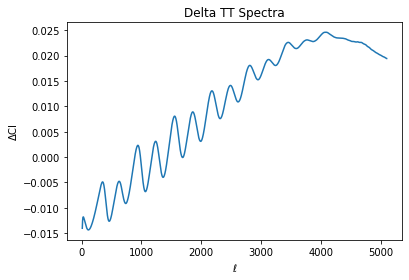

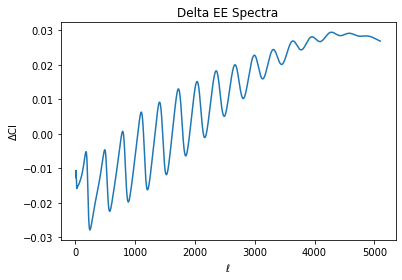

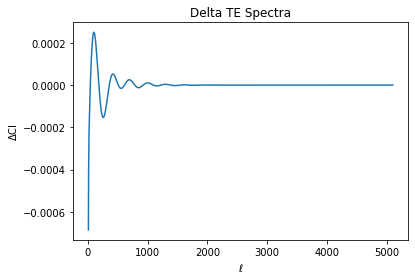

In [16]:
#plot against fiducials
plt.plot(ell[lmin:lmax+1],(Cl_min['TT']-Cl_fid['TT'])/Cl_fid['TT'])
plt.title('Delta TT Spectra')
plt.ylabel('$\Delta$Cl')
plt.xlabel(r'$\ell$')
plt.show()

plt.plot(ell[lmin:lmax+1],(Cl_min['EE']-Cl_fid['EE'])/Cl_fid['EE'])
plt.title('Delta EE Spectra')
plt.ylabel('$\Delta$Cl')
plt.xlabel(r'$\ell$')
plt.show()

plt.plot(ell[lmin:lmax+1],(Cl_min['TE']-Cl_fid['TE']))
plt.title('Delta TE Spectra')
plt.ylabel('$\Delta$Cl')
plt.xlabel(r'$\ell$')
plt.show()

In [ ]:
#run multiple times
n = 10

ombh2_list = []
omch2_list = []
tau_list = []
As_list = []
ns_list = []
thetastar_list = []
nnu_list = []
chi_squared_list = []
for i in range(n):
    #initialize minimizer
    # Initialize the minimize sampler
    info_sampler = {"minimize": {'method':'bobyqa','ignore_prior':False,'override_bobyqa':{'rhoend':0.001}}}
    from cobaya.sampler import get_sampler
    minimize = get_sampler(info_sampler, model=model,
                       packages_path=info["packages_path"])
    #run minimizer
    minimizer.run()
    
    #store value
    ombh2_list.append(minimize.products()['minimum']['ombh2'])
    omch2_list.append(minimize.products()['minimum']['omch2'])
    tau_list.append(minimize.products()['minimum']['tau'])
    As_list.append(minimize.products()['minimum']['As'])
    ns_list.append(minimize.products()['minimum']['ns'])
    thetastar_list.append(minimize.products()['minimum']['thetastar'])
    nnu_list.append(minimize.products()['minimum']['nnu'])
    chi_squared_list.append(minimize.products()['minimum']['chi2'])
    
ombh2_min = np.mean(ombh2_list)
omch2_min = np.mean(omch2_list)
tau_min = np.mean(tau_list)
As_min = np.mean(As_list)
ns_min = np.mean(ns_list)
thetastar_min = np.mean(thetastar_list)
nnu_min = np.mean(nnu_list)
    
print('After averaging over %s solutions, the minimum nnu is %s'%(n,np.mean(nnu_min)))

In [19]:
#get shift
num_nnu_samples = 500
nnu_max_shift = calculate_shift(model, nnu_lower, nnu_upper, num_nnu_samples, nnu_fid, As_fid, ns_fid)


nnu has been shifted by 0.00017234468937887826 by noise and systematics.
The new maximum liklihood is given by 3.0461723446893787


In [ ]:
info = {
        'params': {
            # Fixed
            'tau': tau_fid,
            'thetastar':thetastar_fid,
#            'H0':H0_fid,
#            'mnu': 0.06,
            'ombh2': ombh2_fid,
            'omch2': omch2_fid,
            'As': As_fid,
            'ns': ns_fid,
#            'nnu': nnu_fid,
            # Sampled
#            'nnu': {'prior': {'min': nnu_lower, 'max': nnu_upper}, 'latex': 'nnu','ref':{'dist': 'norm', 'loc':3.046, 'scale':0.06}},
#            'nnu':{'prior':{'min':3.03,'max':3.06},'ref':{'min':3.03,'max':3.06}, 'latex':'nnu'},
#            'ombh2':{'prior':{'min':ombh2_lower,'max':ombh2_upper},'ref':{'min':ombh2_lower,'max':ombh2_upper},'latex':'ombh2'},
#            'omch2':{'prior':{'min':omch2_lower,'max':omch2_upper},'ref':{'min':omch2_lower,'max':omch2_upper},'latex':'omch2'},
#            'H0':{'prior':{'min':H0_lower,'max':H0_upper},'ref':{'min':H0_lower,'max':H0_upper},'latex':'H0'},
#            'tau':{'prior':{'min':tau_lower,'max':tau_upper},'ref':{'min':tau_lower,'max':tau_upper},'latex':'tau'},
#            'thetastar':{'prior':{'min':thetastar_lower,'max':thetastar_upper},'ref':{'min':thetastar_lower,'max':thetastar_upper},'latex':'thetastar'},
#            'As':{'prior':{'min':As_lower,'max':As_upper},'ref':{'min':As_lower,'max':As_upper},'latex':'As'},
#            'ns':{'prior':{'min':ns_lower,'max':ns_upper},'ref':{'min':ns_lower,'max':ns_upper},'latex':'ns'},
            'nnu':{'prior':{'min':nnu_lower,'max':nnu_upper},'ref':{'min':nnu_lower,'max':nnu_upper}, 'latex':'nnu'}},
            # Derived
#            'Map_Cl_at_500': {'latex': r'C_{500,\,\mathrm{map}}'}},
        'likelihood': {'my_cl_like': {
            "external": my_like_multi_spectra,
#            "internal":likelihood.Likelihood.logp,
            # Declare required quantities!
            "requires": {'Cl': {'tt': lmax,'te':lmax,'ee':lmax}}}},
            # Declare derived parameters!
#            "output_params": ['Map_Cl_at_500']}},
        'theory': {'camb': {'stop_at_error': True}},
#        'sampler':'mcmc',
        'packages_path': packages_path}